# MLP



## 0. 변수 변형
- id: 지운다
- age: categorical로 바꾸어서 one-hot encoding
- workclass: 지운다
- fnlwgt: 지운다
- education: 지운다
- education_num: Minmax Scaler + 13이상 1, 13미만 0인 새 변수 생성
- marital_status: 'Married-civ-spouse'는 1, 나머지는 0
- occupation: one-hot encoding
- relationship: 지운다
- race: 'White' or 'Asian-Pac-Islander'는 1, 나머지는 0
- sex: one-hot encoding
- capital_gain: Minmax Scaler + 0이 아니다 1, 0이다 0
- capital_loss: Minmax Scaler + 0이 아니다 1, 0이다 0
- hours_per_week: Minmax Scaler + 50이상 1, 50미만 0인 새 변수 생성
- native_country: 지운다
- income = Target value -> 0('<=50K') or 1('>50K')

## 1. 최적 모델 선택
- layer 수, node 수: 많아도 크게 효과 없다. -> 최대한 줄였다.(16/16/1(output))
- regularizers: l1 사용, 나름 효과가 있음, 0.001로 설정
- dropout: 없는게 나음
- callback 함수: checkpoint만 사용

In [ ]:
# 1. 패키지 import
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yoonskyu","key":"d0dd946765ccff6f96ebaafcb8b36aa3"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle competitions download -c kakr-4th-competition
# !kaggle datasets list

  0% 0.00/399k [00:00<?, ?B/s]
100% 399k/399k [00:00<00:00, 27.3MB/s]
  0% 0.00/683k [00:00<?, ?B/s]
100% 683k/683k [00:00<00:00, 93.7MB/s]
  0% 0.00/43.4k [00:00<?, ?B/s]
100% 43.4k/43.4k [00:00<00:00, 43.3MB/s]


In [ ]:
!ls
!unzip train.csv.zip

drive  kaggle.json  sample_data  sample_submission.csv	test.csv  train.csv.zip
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
# 2. 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
# 3. Preprocessing

# 1) column 제거
def col_reduction(df):
    df.drop(['id','fnlwgt','education','relationship','native_country','workclass'], axis=1, inplace=True)
    
    return df

# 2) marital_status 조정
def mar_st(df):
    df['marital_status'] = (df['marital_status'] == 'Married-civ-spouse').astype(int)
    
    return df

# 3) race 조정
def race(df):
    df['race'] = ((train['race'] == 'White') | (train['race'] == 'Asian-Pac-Islander')).astype(int)

    return df

# 4) capital_gain, loss 조정
def capital(df):
    df['cap_gain_high'] = (df['capital_gain'] != 0).astype(int)
    df['cap_loss_high'] = (df['capital_loss'] >= 1700).astype(int)
    df['capital_gain'] = df['capital_gain'].map(lambda x : np.log(x) if x != 0 else 0)
    
    return df

# 5) age 조정 함수
def age(df):
    df.loc[df['age'] < 20, 'age_range'] = '~20'
    df.loc[df['age'] >= 65, 'age_range'] = '~65'

    down = 20
    for i in range(45//5):
        df.loc[(df['age'] >= down) & (df['age'] < down+5), 'age_range'] = str(down)+'~'+str(down+5)
        down += 5

    df['age'] = df['age_range']
    df.drop(['age_range'], axis=1, inplace=True)
    
    return df
    
# 6) One-hot encoding은 만들지 않았다.

# 7) edu_num 새 변수 만들기
def edu(df):
    df['edu_num_high'] = (df['education_num'] >= 13).astype(int)
    
    return df

# 8) hpw 새 변수 만들기
    
def hpw(df):
    df['hpw_high'] = (df['hours_per_week'] >= 50).astype(int)

    return df

# 9) MinMaxScaler
def mm_feature(df, feature):
    mm_scaler = MinMaxScaler()
    
    df[feature] = mm_scaler.fit_transform(df[feature].values.reshape(-1,1))
    
    return df, mm_scaler

# 10) target 분리: train은 하고, test는 안하므로 따로 만들겠다.
def target_handle(df):
    df['income'] = df['income_>50K']
    df.drop(['income_>50K','income_<=50K'], axis=1, inplace=True)
    
    y_df = df.income
    X_df = df.drop(['income'], axis=1, inplace=False)
    
    return X_df, y_df

def main(df):
    
    df1 = col_reduction(df)
    df2 = mar_st(df1)
    df3 = race(df2)
    df4 = capital(df3)
    df5 = age(df4)
    
    df6 = pd.get_dummies(df5)
    
    df7 = edu(df6)
    df_fin = hpw(df7)
    
    return df_fin

In [ ]:
# 적용
## main: 1) ~ 7)
train = main(train)
X_test = main(test)

## 8) minmax scaler
train, mm_scaler1 = mm_feature(train, 'education_num')
train, mm_scaler2 = mm_feature(train, 'hours_per_week')
train, mm_scaler3 = mm_feature(train, 'capital_gain')
train, mm_scaler4 = mm_feature(train, 'capital_loss')

X_test['education_num'] = mm_scaler1.transform(X_test['education_num'].values.reshape(-1,1))
X_test['hours_per_week'] = mm_scaler2.transform(X_test['hours_per_week'].values.reshape(-1,1))
X_test['capital_gain'] = mm_scaler3.transform(X_test['capital_gain'].values.reshape(-1,1))
X_test['capital_loss'] = mm_scaler4.transform(X_test['capital_loss'].values.reshape(-1,1))

## 9) X, y split
X_train, y_train = target_handle(train)

In [ ]:
# real_test data 불러오기
real_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/answer.csv')

In [ ]:
r_test = (real_test['income'] == '>50K').astype(int)

In [ ]:
r_test = np.array(r_test).reshape((-1,1))

In [ ]:
# train, validation split
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=True,
                                                      stratify=y_train)

In [ ]:
model = Sequential()

model.add(Dense(16, input_dim=X_train_.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.001)))
# input_dim: feature 수, 다음 층에서는 적을 필요 없다.
# units는 생략 가능

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                624       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 64
nb_epochs = 100

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_, y_train_,
              batch_size=batch_size,
              epochs=nb_epochs,
              validation_data=(X_val_, y_val_))

Epoch 1/100
326/326 [==============================] - 1s 2ms/step - loss: 0.5887 - accuracy: 0.7716 - val_loss: 0.4408 - val_accuracy: 0.8405
Epoch 2/100
326/326 [==============================] - 0s 1ms/step - loss: 0.4237 - accuracy: 0.8411 - val_loss: 0.4099 - val_accuracy: 0.8438
Epoch 3/100
326/326 [==============================] - 0s 1ms/step - loss: 0.4025 - accuracy: 0.8423 - val_loss: 0.3950 - val_accuracy: 0.8401
Epoch 4/100
326/326 [==============================] - 0s 1ms/step - loss: 0.3917 - accuracy: 0.8419 - val_loss: 0.3879 - val_accuracy: 0.8430
Epoch 5/100
326/326 [==============================] - 0s 1ms/step - loss: 0.3850 - accuracy: 0.8431 - val_loss: 0.3849 - val_accuracy: 0.8445
Epoch 6/100
326/326 [==============================] - 0s 1ms/step - loss: 0.3805 - accuracy: 0.8427 - val_loss: 0.3795 - val_accuracy: 0.8430
Epoch 7/100
326/326 [==============================] - 0s 1ms/step - loss: 0.3767 - accuracy: 0.8441 - val_loss: 0.3763 - val_accuracy: 0.8432

In [ ]:
train_acc = model.evaluate(X_train_, y_train_)
val_acc = model.evaluate(X_val_, y_val_)
# 분류 문제는 confusion matrix를 만들어서 평가

print("Train acc :", train_acc)
print("Val acc :", val_acc)

163/163 [==============================] - 0s 819us/step - loss: 0.3450 - accuracy: 0.8520
Train acc : [0.3380482494831085, 0.8522002100944519]
Val acc : [0.34502875804901123, 0.8520153760910034]


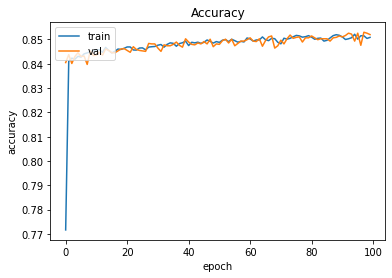

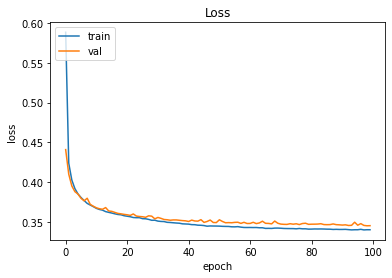

In [ ]:
# 시각화
plt.plot(history.history['accuracy']) # train acc
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) # train acc
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
y_val_predict = np.rint(model.predict(X_val_)).astype(int)

print(f1_score(y_val_, y_val_predict, average='micro'))

0.8520153550863724


In [ ]:
y_predict = np.rint(model.predict(X_test)).astype(int)

f1_score(r_test, y_predict, average='micro')

0.703009828009828

In [ ]:
sample_submission['prediction'] = y_predict
sample_submission.to_csv('submission_dl_default.csv', index=False)

## 2. 데이터 조정
- train, test 함께할 때, 성능이 조금씩 좋아지는 듯 해보였다. => 반복해보자

In [ ]:
# train, test 합치기 - default 과정 선행 필요
X = pd.concat([X_train, X_test])

In [ ]:
y_predict = pd.Series(y_predict.reshape((-1)))

In [ ]:
y = pd.concat([y_train, y_predict])

In [ ]:
val_f1_lst = []
test_f1_lst = []

for i in range(10):
    print('='*20,i+1,'번째','='*20)
    # train, validation split
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X, y,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=True,
                                                          stratify=y)
    
    model = Sequential()

    model.add(Dense(16, input_dim=X_train_.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.001)))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.001)))
    # input_dim: feature 수, 다음 층에서는 적을 필요 없다.
    # units는 생략 가능

    model.summary()

    batch_size = 64
    nb_epochs = 100

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_, y_train_,
                        batch_size=batch_size,
                        epochs=nb_epochs,
                        validation_data=(X_val_, y_val_))
    
    train_acc = model.evaluate(X_train_, y_train_)
    val_acc = model.evaluate(X_val_, y_val_)
    # 분류 문제는 confusion matrix를 만들어서 평가

    print("Train acc :", train_acc)
    print("Val acc :", val_acc)

    y_val_predict = np.rint(model.predict(X_val_)).astype(int)

    val_f1_lst.append(f1_score(y_val_, y_val_predict, average='micro'))

    y_predict = np.rint(model.predict(X_test)).astype(int)

    test_f1_lst.append(f1_score(r_test, y_predict, average='micro'))

    sample_submission['prediction'] = y_predict
    sample_submission.to_csv('submission_dl_train_test_{}.csv'.format(i), index=False)

    y_predict = pd.Series(y_predict.reshape((-1)))
    y = pd.concat([y_train, y_predict])
    print('='*60)

==================== 1 번째 ====================
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                624       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
407/407 [==============================] - 1s 2ms/step - loss: 0.5137 - accuracy: 0.8242 - val_loss: 0.3817 - val_accuracy: 0.8657
Epoch 2/100
407/407 [==============================] - 1s 1ms/step - loss: 0.3712 - accuracy: 0.8649 - val_loss: 0.3581 - val_accuracy: 0.8637
Epoch 3/100
407/407 [==============================] 

In [ ]:
for i in range(10):
    print('='*40)
    print('val_f1_score: {}'.format(val_f1_lst[i]))
    print('test_f1_score:{}'.format(test_f1_lst[i]))

val_f1_score: 0.8747121142330723
test_f1_score:0.7071560196560197
val_f1_score: 0.8777828957469676
test_f1_score:0.7120700245700246
val_f1_score: 0.8783970520497466
test_f1_score:0.715448402948403
val_f1_score: 0.877475817595578
test_f1_score:0.7129914004914004
val_f1_score: 0.876861661292799
test_f1_score:0.7086916461916463
val_f1_score: 0.8790112083525257
test_f1_score:0.7066953316953317
val_f1_score: 0.8782435129740519
test_f1_score:0.7077702702702703
val_f1_score: 0.8785505911254414
test_f1_score:0.7050061425061425
val_f1_score: 0.8802395209580839
test_f1_score:0.7028562653562653
val_f1_score: 0.8779364348226624
test_f1_score:0.7013206388206388
